In [29]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [1]:
from pyspark.sql import SparkSession
import pyspark
import findspark

findspark.init()
pyspark.SparkContext.setSystemProperty('spark.executor.memory', '4g')
sc = pyspark.SparkContext(appName="test")
spark_sql = SparkSession.builder.appName("test").getOrCreate()

In [48]:
from bicis.etl.build_series import BuildAllSeries, _translate_doc
input_fname = BuildAllSeries().requires()[2].output().path
input_fname

'/Users/przivic/prog/bicis/bicis/lib/../../data/rents_by_hour.csv'

In [66]:
df = (spark_sql
    .read
    .load(input_fname, format="csv", sep=",", inferSchema="true", header="true")
)

In [67]:
a = df.filter(df.station == 'RETIRO').toPandas()

In [69]:
a.sort_values('hour')

,station,hour,n_rents,n_returns
47,RETIRO,0,72,129
42,RETIRO,0,248,238
25,RETIRO,1,124,131
46,RETIRO,1,43,30
5,RETIRO,2,11,10
15,RETIRO,2,76,104
7,RETIRO,3,4,4
12,RETIRO,3,44,67
27,RETIRO,4,26,68
3,RETIRO,4,5,12


<IPython.core.display.Javascript object>


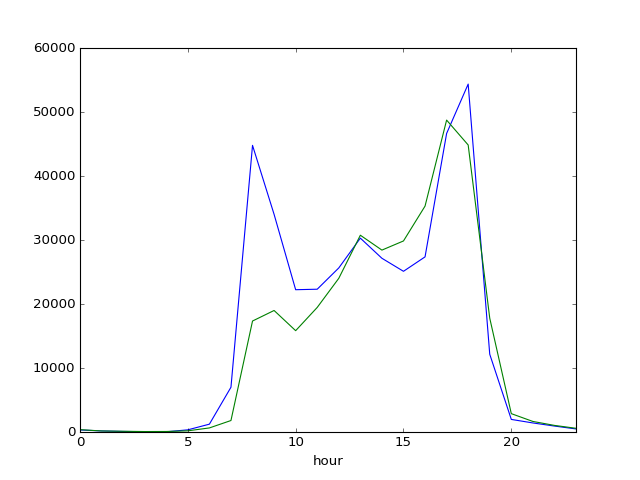

In [46]:
rdf = df.filter(df.station == 'RETIRO').toPandas()
# figure()
# rdf.n_rents.plot()
# rdf.n_returns.plot()
figure()
rdf.groupby('hour').n_rents.sum().plot()
rdf.groupby('hour').n_returns.sum().plot()

In [38]:
# figure()
rdf = df.filter(df.station == 'RETIRO').toPandas().set_index('month').sort_index()
figure()
rdf.n_rents.plot()
rdf.n_returns.plot()

KeyError: 'month'

In [56]:
from bicis.etl.unify_raw_data import UnifyRawData

key = 'hour'

general_df = (
    spark_sql
        .read
        .load(
            UnifyRawData().output().path.replace('.csv', '_sample.csv'),
            format="csv",
            sep=",",
            inferSchema="true",
            header="true")
        .rdd
        .map(_translate_doc)
        .toDF()
)

general_df = general_df.filter((general_df.src_station == 'RETIRO') | (general_df.dst_station == 'RETIRO'))

n_rents = (
    general_df
    .groupBy('src_station', 'rent_date_' + key)
    .count()
    .withColumnRenamed('count', 'n_rents')
    .withColumnRenamed('src_station', 'station')
    .withColumnRenamed('rent_date_' + key, key)
)

n_returns = (
    general_df
    .groupBy('dst_station', 'return_date_' + key)
    .count()
    .withColumnRenamed('count', 'n_returns')
    .withColumnRenamed('dst_station', 'station')
    .withColumnRenamed('return_date_' + key, key)
)



In [55]:
n_rents.toPandas().sort_values('hour')

,station,hour,n_rents
7,RETIRO,7,32
13,RETIRO,8,218
12,RETIRO,9,202
1,RETIRO,10,118
0,RETIRO,11,79
10,RETIRO,12,84
3,RETIRO,13,116
2,RETIRO,14,106
11,RETIRO,15,93
6,RETIRO,16,106


In [60]:
a = n_rents.join(n_returns, ['station', key])

pdf = a.filter(a.station == 'RETIRO').toPandas()

In [62]:
pdf.sort_values('hour')

,station,hour,n_rents,n_returns
7,RETIRO,7,32,2
13,RETIRO,8,218,31
12,RETIRO,9,202,46
1,RETIRO,10,118,38
0,RETIRO,11,79,75
10,RETIRO,12,84,73
3,RETIRO,13,116,133
2,RETIRO,14,106,142
11,RETIRO,15,93,120
6,RETIRO,16,106,158


In [ ]:
(
    n_rents
    .join(n_returns, ['station', key])
    .write
    .csv(self.output().path, header='true')
)
